In [20]:
import os
import sys
import pickle
import random
import numpy as np
import pandas as pd
import lightgbm as lgb
import config

sys.path.append('..')
from library import load_master
from library.utils.binary_classification.modeling import evaluate_model

In [2]:
df_train = pickle.load(open(os.path.join(config.data_p_dir, 'df_train.pkl'), 'rb'))
df_master = load_master.load_master(df_train, os.path.join(config.data_f_dir, 'train'), join_keys=['id'])

In [3]:
df_master.shape

(2386133, 187)

In [4]:
df_master = df_master.fillna(-1)
df_master[['f'+str(x) for x in range(2, 22)]] = df_master[['f'+str(x) for x in range(2, 22)]].applymap(lambda x: str(x).replace(',', ''))
df_master[['f'+str(x) for x in range(2, 22)]] = df_master[['f'+str(x) for x in range(2, 22)]].astype('float')

In [5]:
df_master.head()

,id,core_cust_id,prod_code,prod_type,deal_date,y,feature_app_dtedff_3_all,feature_app_dtedff_3_r3_1,feature_app_dtedff_3_type_a,feature_app_dtedff_3_type_b,...,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21
0,4e3c3d57b83e425f8087b1d6d32a50f7,6e2105d9fe,90318011,4,2021-08-01,0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,aa83c5fc05414c4d9727f0b32882f80e,6e2105d9fe,GRHLA20211530,1,2021-09-01,0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,11245458ed6446cd9f88d57a5fc1d957,6e2105d9fe,DECD21090102,2,2021-09-01,0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,359a03ecc46240d9bc00eef58dbc85e3,6e2105d9fe,GRHLA20211119,1,2021-08-01,0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,7a5d79036dfb46acb7348e741ab00d9f,6e2105d9fe,GRHLA20211125,1,2021-08-01,0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [7]:
import importlib
importlib.reload(load_master)

<module 'library.load_master' from '../library/load_master.py'>

In [8]:
df_ins, df_oos = load_master.split_samples(df_master=df_master, split_keys=['id'], ins_size=0.8, random_seed=config.random_seed)

In [45]:
a = df_ins.iloc[0]

In [54]:
df_ = pd.DataFrame(index=df_ins.columns)

In [56]:
df_.join(a)

,0
id,4e3c3d57b83e425f8087b1d6d32a50f7
core_cust_id,6e2105d9fe
prod_code,90318011
prod_type,4
deal_date,2021-08-01 00:00:00
...,...
f17,-1.0
f18,-1.0
f19,-1.0
f20,-1.0


In [58]:
a.name

0

In [9]:
df_ins.shape

(1907961, 187)

In [10]:
df_oos.shape

(478172, 187)

In [12]:
# random.seed(config.random_seed)
df_master['random_number'] = [random.random() for x in range(len(df_master))]

df_master_ins = df_master.loc[df_master['random_number'] <= 0.8, ]
print(df_master_ins.shape)
df_master_oos = df_master.loc[df_master['random_number'] > 0.8, ]
print(df_master_oos.shape)

(1910288, 188)
(475845, 188)


In [13]:
features = df_master_oos.columns[6:-2]
features

Index(['feature_app_dtedff_3_all', 'feature_app_dtedff_3_r3_1',
       'feature_app_dtedff_3_type_a', 'feature_app_dtedff_3_type_b',
       'feature_app_dtedff_3_type_c', 'feature_app_dtedff_3_type_d',
       'feature_app_dtedff_3_r5_0_6', 'feature_app_dtedff_3_r5_6_11',
       'feature_app_dtedff_3_r5_12_17', 'feature_app_dtedff_3_r5_18_23',
       ...
       'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20'],
      dtype='object', length=180)

In [14]:
lgb_ins = lgb.Dataset(data=df_master_ins[features], label=df_master_ins['y'])
lgb_oos = lgb.Dataset(data=df_master_oos[features], label=df_master_oos['y'])

In [15]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': ['auc'],
    # 'max_depth': 5,
    # 'num_leaves': 8,
    'min_data_in_leaf': 10000,
    'learning_rate': 0.1,
    'feature_fraction': 0.7,
    'bagging_fraction': 1,
    'bagging_freq': 3,
    'lambda_l1': 1,
    'random_state': 2022
}

In [16]:
bst_md = lgb.train(
    params=params, 
    train_set=lgb_ins, 
    valid_sets=[lgb_oos],
    num_boost_round=1000,
    early_stopping_rounds=5
)

[LightGBM] [Info] Number of positive: 20369, number of negative: 1889919
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.605717 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 22403
[LightGBM] [Info] Number of data points in the train set: 1910288, number of used features: 145
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.010663 -> initscore=-4.530275
[LightGBM] [Info] Start training from score -4.530275
[1]	valid_0's auc: 0.874483
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.876153
[3]	valid_0's auc: 0.876503
[4]	valid_0's auc: 0.87679
[5]	valid_0's auc: 0.876932
[6]	valid_0's auc: 0.877175
[7]	valid_0's auc: 0.877486
[8]	valid_0's auc: 0.877728
[9]	valid_0's auc: 0.877793
[10]	valid_0's auc: 0.87786
[11]	valid_0's auc: 0.877908
[12]	valid_0's auc: 0.877962
[13]	valid_0's auc: 0.878247
[14]	va

In [17]:
bst_md_imp = pd.DataFrame({
    'features': features, 
    'imp_split': bst_md.feature_importance(importance_type='split'),
    'imp_gain': bst_md.feature_importance(importance_type='gain')
})
bst_md_imp = bst_md_imp.sort_values(by='imp_gain', ascending=False)
# bst_md_imp.to_csv(os.path.join(result_path_final, 'lgb_featureimp.csv'))
bst_md_imp.iloc[:50]

,features,imp_split,imp_gain
129,u_p_trade_apply_amt_mean_p3m,14,170221.742465
60,feature_app_dtedff_360_all,25,85327.933497
32,feature_app_dtedff_30_type_a,49,35180.147752
61,feature_app_dtedff_360_r3_1,6,23769.180763
158,d2,133,9277.855510
109,u_p_trade_cnt_sum_l1m,26,3195.796929
70,u_p_trade_elaspsed_day_min,55,3094.105777
71,u_p_trade_elaspsed_day_max,52,2957.634775
131,u_p_trade_apply_amt_min_p3m,16,2042.654430
5,feature_app_dtedff_3_type_d,42,1892.730375


In [43]:
bst_md.params

{'boosting_type': 'gbdt',
 'objective': 'binary',
 'metric': ['auc'],
 'min_data_in_leaf': 10000,
 'learning_rate': 0.1,
 'feature_fraction': 0.7,
 'bagging_fraction': 1,
 'bagging_freq': 3,
 'lambda_l1': 1,
 'random_state': 2022,
 'num_iterations': 1000,
 'early_stopping_round': 5}

In [18]:
df_master_ins.loc[:, 'score'] = bst_md.predict(df_master_ins.loc[:, features], num_iteration=bst_md.best_iteration)
df_master_oos.loc[:, 'score'] = bst_md.predict(df_master_oos.loc[:, features], num_iteration=bst_md.best_iteration)

/Users/xiangxiaowei/opt/miniconda3/envs/mlpy37/lib/python3.7/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [22]:
ins_pr_df = evaluate_model.calc_pr(y_true=df_master_ins['y'], y_score=df_master_ins['score'])
ins_pr_df['F2'] = 5*ins_pr_df['recall']*ins_pr_df['precision']/(4*ins_pr_df['precision']+ins_pr_df['recall'])
ins_pr_df.describe()

,precision,recall,thresholds,F2
count,110476.000000,110476.000000,110475.000000,110476.000000
mean,0.166515,0.589976,0.079935,0.256226
std,0.178523,0.231757,0.134728,0.068550
min,0.010921,0.000000,0.000430,0.000000
25%,0.059856,0.428789,0.016514,0.209391
50%,0.094437,0.637341,0.034119,0.268832
75%,0.181044,0.791301,0.066927,0.314473
max,1.000000,1.000000,0.928960,0.337851


In [40]:
a = ins_pr_df.loc[np.where(ins_pr_df['F2'] == ins_pr_df['F2'].max())[0], 'thresholds']
a

81022    0.063153
Name: thresholds, dtype: float64

In [41]:
'{0}'.format(a)

'81022    0.063153\nName: thresholds, dtype: float64'

In [ ]:
oos_pr_df = evaluate_model.calc_pr(y_true=df_master_oos['y'], y_score=df_master_oos['score'])
oos_pr_df['F2'] = 5*oos_pr_df['recall']*oos_pr_df['precision']/(4*oos_pr_df['precision']+oos_pr_df['recall'])
oos_pr_df.describe()

In [ ]:
evaluate_model.plot_pr_curve({'lgb': oos_pr_df})

In [85]:
from library.utils.binary_classification.var_process import var_binning
from library.utils.binary_classification.var_analysis import woe_tool


---------------- [feature_app_dtedff_360_all : Auto binning] ----------------
PARAMS: max_bins=6, min_cnt_in_bin=95486.0, criteria=chisq
-------- [feature_app_dtedff_360_all : EquiX Binning] --------
PARAMS: bins=20, equi_method=equif
-------- [feature_app_dtedff_360_all : Auto binning] --------
LoopMerge: round=0, bins=1 -> 1
Chi2Merge: round=0, bins=1 -> 1


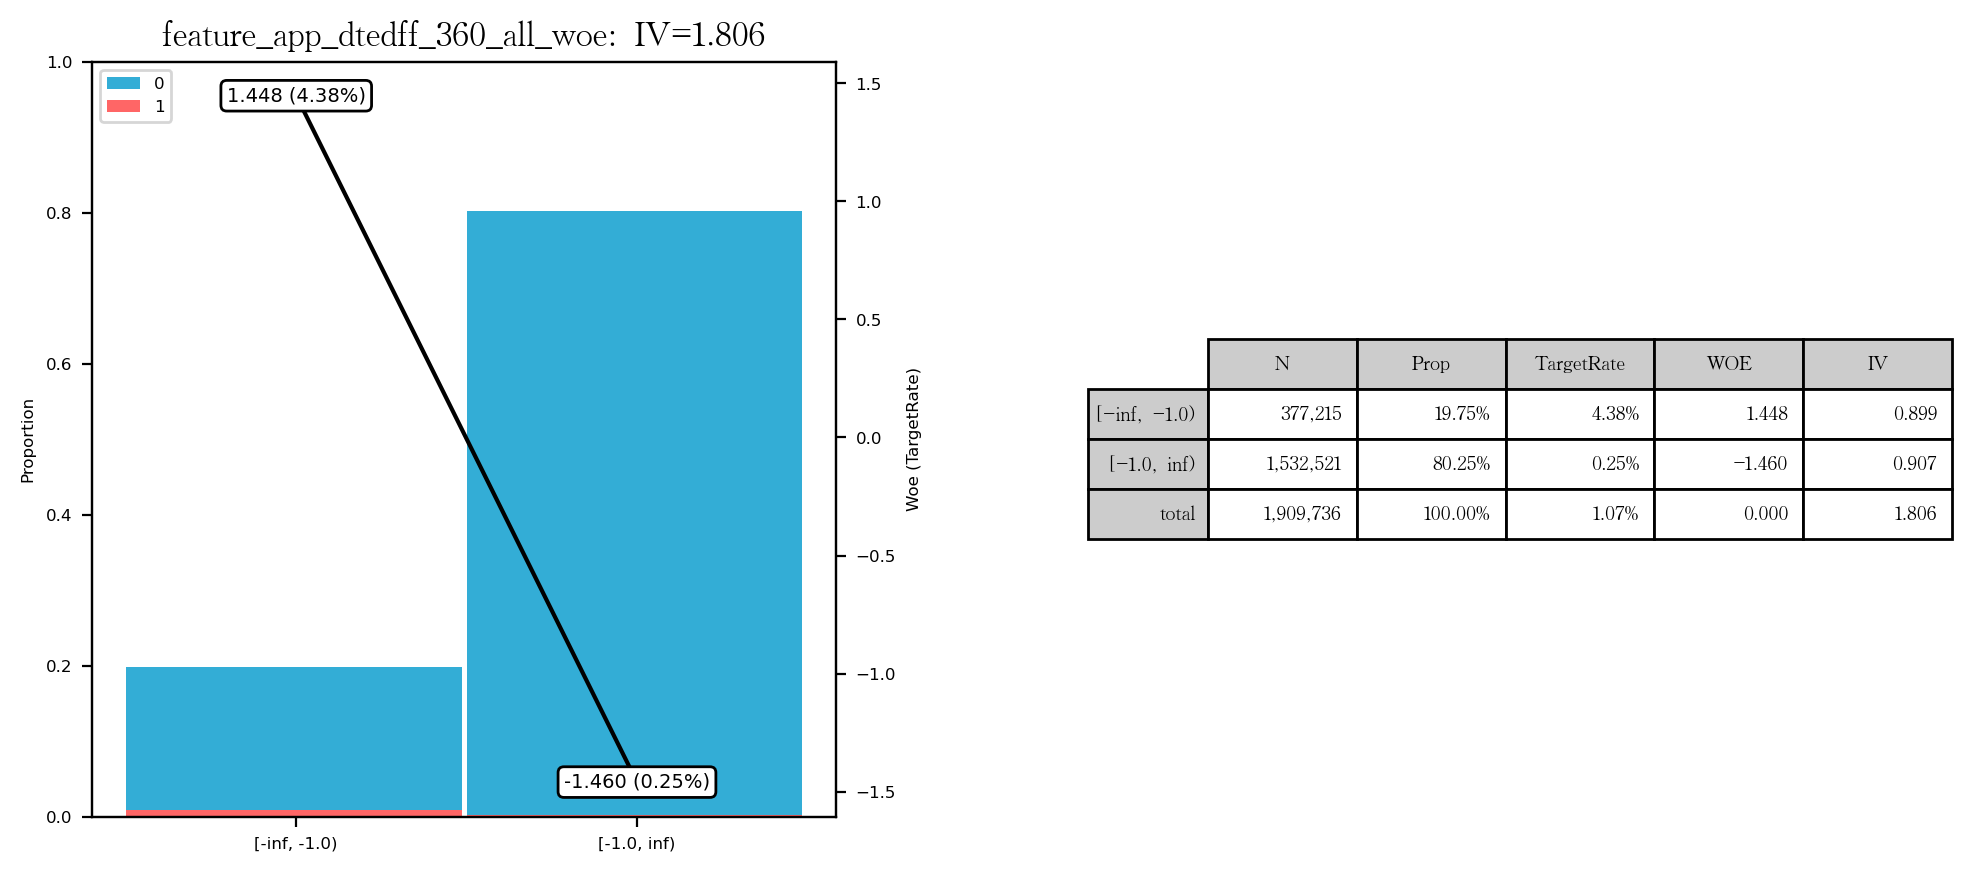

TypeError: sequence item 0: expected str instance, Timestamp found

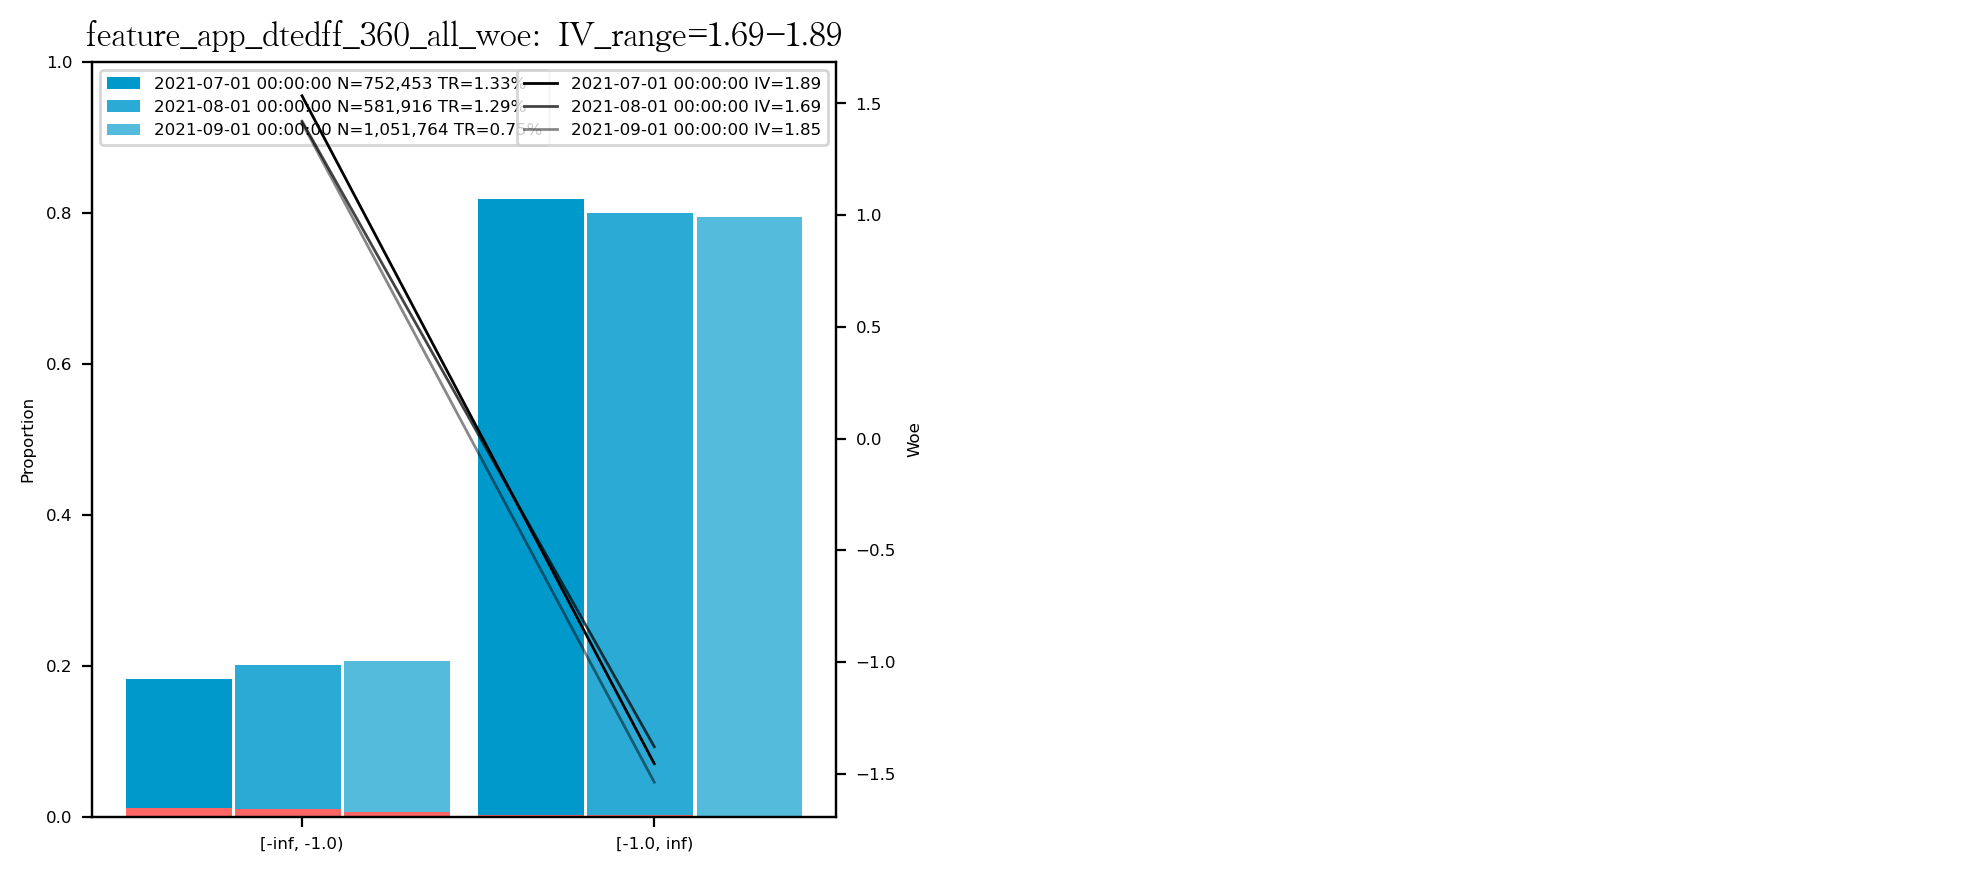

In [95]:
var_name = 'feature_app_dtedff_360_all' # 'u_p_trade_apply_amt_max_p2m'
tgt_name = 'y'
var_woe_name = var_name + '_woe'

nvb = var_binning.NumVarBinning(
    var_name=var_name, 
    spec_values=[-1], 
    spec_digit=3
    )

binning_series = nvb.auto_binning(
    df=df_master_ins,
    tgt_name=tgt_name,
    max_bins=6,
    min_prop_in_bin=0.05,
    equi_method='equif',
    equi_bins=20,
    binning_criteria='chisq'
    )

df = df_master_ins[[var_name, tgt_name]].copy()
df[var_woe_name] = binning_series
df_woe = woe_tool.cre_woe_table(df=df, var_name=var_woe_name, tgt_name=tgt_name)
woe_tool.plot_reference(df_woe, to_show=True)

df_group = df_master[[var_name, tgt_name, 'deal_date']].copy()
df_group[var_woe_name] = nvb.apt_binning(df=df_group, points=nvb.cut_points, modify=False)    
df_group_woe = woe_tool.cre_group_woe_table(df=df_group, var_name=var_woe_name, group_name='deal_date', tgt_name=tgt_name)
woe_tool.plot_group_reference(df_group_woe, to_show=True)

In [35]:
np.percentile(df_master['score'], 99)

0.12187230288290775

#### df_test

In [49]:
df_test = pickle.load(open(os.path.join(config.data_p_dir, 'df_test.pkl'), 'rb'))
print(df_test.shape)
test_feature_u_p_trade = pickle.load(open(os.path.join(config.data_f_dir, 'test_feature_u_p_trade.pkl'), 'rb'))
test_feature_app = pd.read_csv(os.path.join(config.data_f_dir, 'test_feature_app.csv'))
test_feature_basci = pd.read_csv(os.path.join(config.data_f_dir, 'test_feature_basci.csv'))

(567362, 5)


In [50]:
df_master_test = pd.merge(df_test, test_feature_u_p_trade, on=['id'], how='left')
df_master_test = pd.merge(df_master_test, test_feature_app, on=['id'], how='left')
df_master_test = pd.merge(df_master_test, test_feature_basci, on=['id'], how='left')

In [51]:
df_master_test.head()

,id,core_cust_id,prod_code,prod_type,deal_date,u_p_trade_elaspsed_day_min,u_p_trade_elaspsed_day_max,u_p_trade_cnt,u_p_trade_apply_amt_sum,u_p_trade_apply_amt_avg,...,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21
0,014d5e46cd2e47f2ba2958a085ffc069,548481d891,GRHLA20211729,1,2021-10-01,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,6e0cf8346acb4c818f79b5b51d6f408e,548481d891,91318017,4,2021-10-01,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,aff6a912581747119c0f1dcaff3f2d0d,548481d891,GRZSA2021029,1,2021-10-01,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4dac8b01f5a24545a9c3acd375f2a56b,548481d891,GRHLA20211836,1,2021-10-01,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1b3d29eb5ef846cea13ae33a523ed732,548481d891,DECD21090104,2,2021-10-01,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [52]:
df_master_test = df_master_test.fillna(-1)
df_master_test[['f'+str(x) for x in range(2, 22)]] = df_master_test[['f'+str(x) for x in range(2, 22)]].applymap(lambda x: str(x).replace(',', ''))
df_master_test[['f'+str(x) for x in range(2, 22)]] = df_master_test[['f'+str(x) for x in range(2, 22)]].astype('float')

In [53]:
df_master_test['y'] = bst_md.predict(df_master_test.loc[:, features], num_iteration=bst_md.best_iteration)

In [54]:
df_master_test[['id','y']].to_csv(os.path.join(config.result_p_dir, 'lgb_f2_20220111.csv'), index=False, )

In [56]:
df_master_test[['id','y']]

,id,y
0,014d5e46cd2e47f2ba2958a085ffc069,0.002668
1,6e0cf8346acb4c818f79b5b51d6f408e,0.002668
2,aff6a912581747119c0f1dcaff3f2d0d,0.002668
3,4dac8b01f5a24545a9c3acd375f2a56b,0.002668
4,1b3d29eb5ef846cea13ae33a523ed732,0.002668
...,...,...
567357,a95980107328466eb7d67accc2810193,0.082642
567358,9080af08e056409f8b3ca32fbea03af1,0.105880
567359,323ed9139ecb4a5286f61e58ce3e3bab,0.118332
567360,341e0b03d13241b88568d440fd0871d2,0.172827


In [48]:
df_master_test.shape

(567362, 198)